# `CLOUD.jl` - 2D linear advection

In [55]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_collapsed_2D_skew_p4M4_linear_test/"
results_path = "../results/advection_collapsed_2D_skew_p4M4_test/";

Define the physical problem

In [56]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

Set plotting and post-processing options

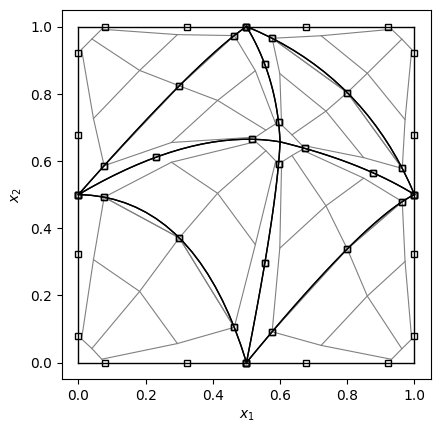

In [57]:
M = 2
p = 2
p_map = p
form = WeakConservationForm()
mesh_strategy = ZigZag()
strategy=Lazy()

reference_approximation =ReferenceApproximation(
    CollapsedModal(p), Tri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()), 
    chain_rule_diff=true, mapping_degree=p_map,
    N_plot=ceil(Int,50/M));
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), strategy=mesh_strategy), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=false, geometry_resolution=20)

In [58]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s-2
linear_analysis = LinearAnalysis(results_path, conservation_law, spatial_discretization,
    LinearResidual(solver), r=r, tol=tol)
plotter = Plotter(spatial_discretization, plots_path);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [59]:
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
reset_timer!()
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, 
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
print_timer()
save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            2.28s /  97.4%           1.04GiB /  99.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 rhs!                   8.54k    2.22s  100.0%   260μs   1.04GiB  100.0%   127KiB
   eval residual        68.3k    1.30s   58.3%  19.0μs    615MiB   57.9%  9.22KiB
     volume terms       68.3k    881ms   39.6%  12.9μs    482MiB   45.4%  7.22KiB
     facet terms        68.3k    136ms    6.1%  1.99μs   76.1MiB    7.2%  1.14KiB
     mass matrix solve  68.3k   89.6ms    4.0%  1.31μs   40.6MiB    3.8%     624B
   extrapolate solu...  68.3k    266ms   12.0%  3.89μs    183MiB   17.3%  2.75KiB
   eval numeric

Visualize the solution

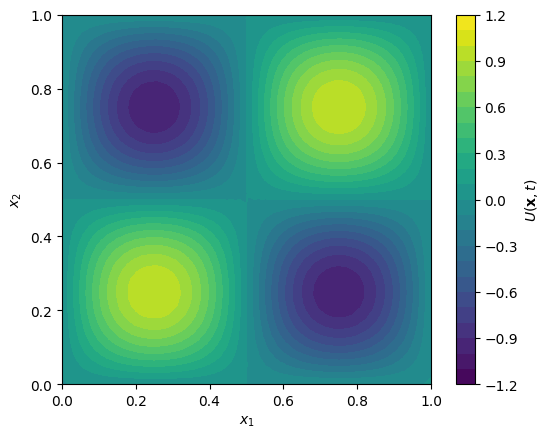

In [60]:
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

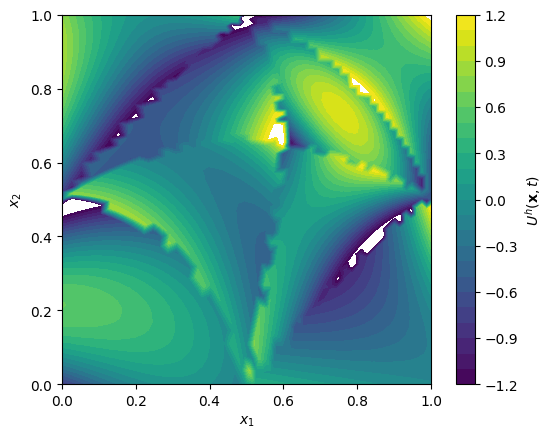

In [61]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [62]:
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.45452895246871694]
Conservation (initial/final/diff):
[-0.001706902710658674][-0.0017069027106586254][4.85722573273506e-17]
Energy (initial/final/diff):
[0.2476984793669654][0.30393936948857314][0.05624089012160774]


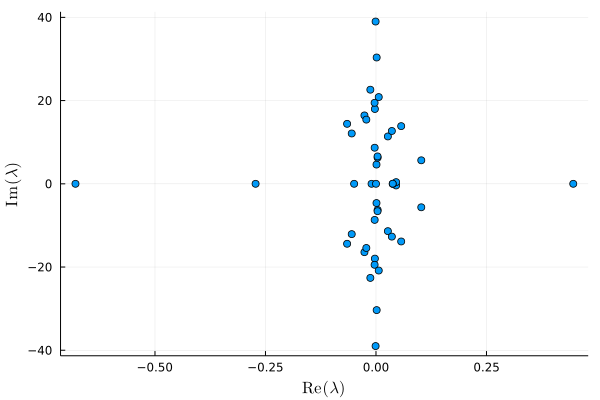

In [64]:
linear_results = analyze(linear_analysis)
plot_spectrum(linear_analysis, linear_results.λ, unit_circle=false, label="\\lambda", numbering=false)

In [66]:
using UnPack
@unpack VOL = solver.operators[1]

CLOUD.Solvers.PhysicalOperators{2}((6×9 LinearMaps.LinearCombination{Float64} with 2 maps:
  6×9 LinearMaps.CompositeMap{Float64} with 5 maps:
    9×9 LinearMaps.WrappedMap{Float64} of
      9×9 Diagonal{Float64, Vector{Float64}}
    9×9 LinearMaps.WrappedMap{Float64} of
      9×9 Diagonal{Float64, Vector{Float64}}
    9×9 LinearMaps.WrappedMap{Float64} of
      9×9 Diagonal{Float64, Vector{Float64}}
    9×9 TensorProductMap{Float64}
    6×9 LinearMaps.WrappedMap{Float64} of
      6×9 adjoint(::Matrix{Float64}) with eltype Float64
  6×9 LinearMaps.CompositeMap{Float64} with 4 maps:
    9×9 LinearMaps.WrappedMap{Float64} of
      9×9 Diagonal{Float64, Vector{Float64}}
    9×9 LinearMaps.WrappedMap{Float64} of
      9×9 Diagonal{Float64, Vector{Float64}}
    9×9 LinearMaps.LinearCombination{Float64} with 2 maps:
      9×9 LinearMaps.CompositeMap{Float64} with 2 maps:
        9×9 LinearMaps.WrappedMap{Float64} of
          9×9 Diagonal{Float64, Vector{Float64}}
        9×9 TensorProductMa

In [67]:
Matrix(VOL[1])

6×9 Matrix{Float64}:
 -1.73472e-18   2.10989e-18  -5.42101e-18  …   8.3538e-18  -5.55112e-17
 -0.0810399    -0.0740741    -0.0115527       -0.0389078   -0.0214878
  0.264675      0.241925      0.0377308       -0.141352    -0.078065
 -0.0526256    -0.0842009    -0.0526256       -0.0258379   -0.0161487
  0.28639       0.103125      0.0328146       -0.102046    -0.0729033
  0.11938      -0.0676201    -0.203905     …  -0.00550707  -0.0122412